In [1]:
"""Data inspection."""

'Data inspection.'

In [68]:
import csv
import glob
import matplotlib
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import animation
import nibabel
import os
import sklearn
import shutil

import torch
import numpy as np
import pickle
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider, FloatSlider
import ipywidgets as widgets

import importlib
import analyze
importlib.reload(analyze)
import datasets
importlib.reload(datasets)
import vis
importlib.reload(vis)

import nn
importlib.reload(nn)

NEURO_DIR = '/neuro/'
TRAIN_VAL_DIR = os.path.join(NEURO_DIR, 'train_val_datasets')
OUTPUT = '/scratch/users/nmiolane/output_fmri'
DEVICE='cuda'

IMG_SHAPE = (96, 96)
SHAPE_STR = datasets.get_shape_string(IMG_SHAPE)
TRAIN_IMG_PATH = os.path.join(TRAIN_VAL_DIR, 'train_fmri_%s.npy' % SHAPE_STR)
METADATA_CSV = '/neuro/train_val_datasets/train_fmri_%s_labels.csv' % SHAPE_STR

### Inspect MakeDataset

WARNING: There are no more images in the saved trained images

Loading /neuro/train_val_datasets/train_fmri_96x96.npy
Dataset shape: (12437, 1, 96, 96)


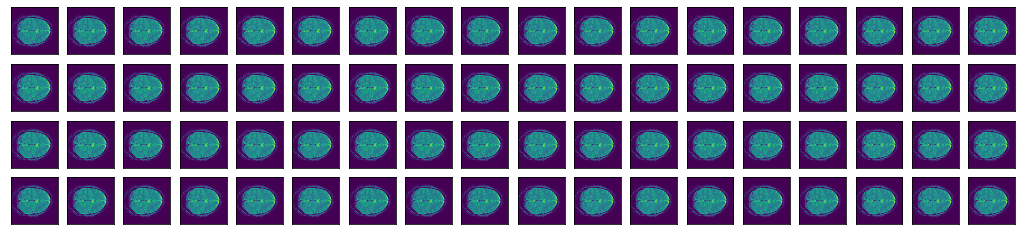

In [12]:
vis.show_data(TRAIN_IMG_PATH, cmap='viridis')

Shape of img data:
(20, 1, 96, 96)
Shape of recon:
(20, 1, 96, 96)


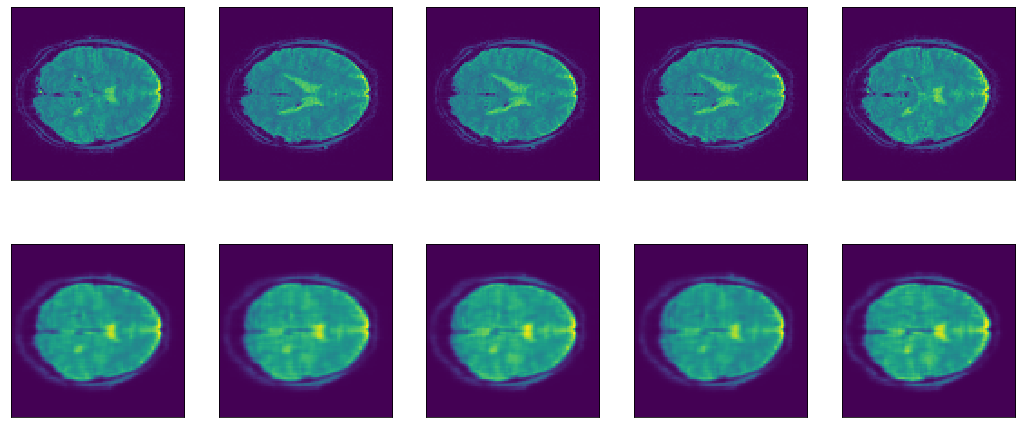

In [13]:
epoch_id=1
vis.plot_img_and_recon(OUTPUT, epoch_id=epoch_id, cmap='viridis')

Shape of img data:
(20, 1, 96, 96)
Shape of recon:
(20, 1, 96, 96)


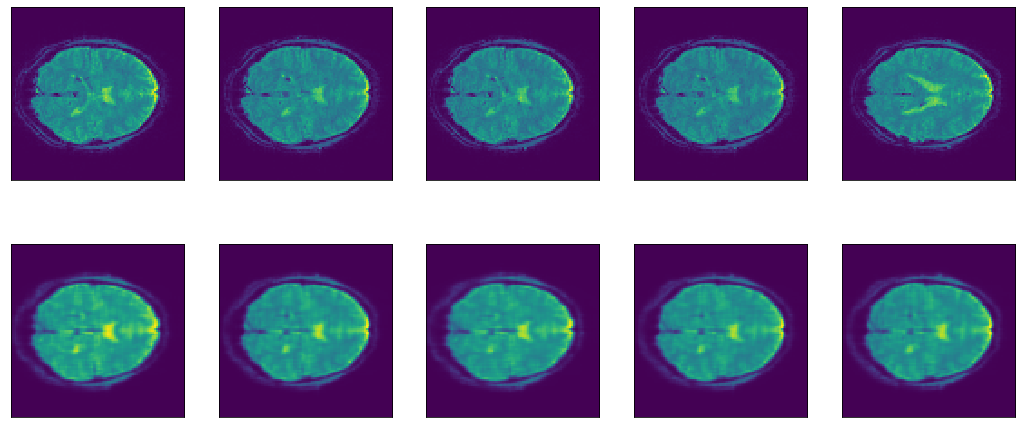

In [14]:
epoch_id=2
vis.plot_img_and_recon(OUTPUT, epoch_id=epoch_id, cmap='viridis')

Shape of img data:
(20, 1, 96, 96)
Shape of recon:
(20, 1, 96, 96)


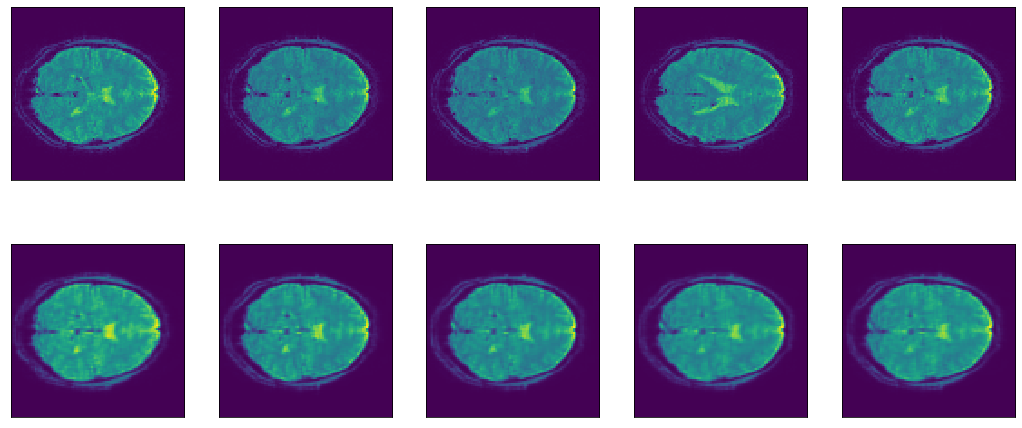

In [15]:
epoch_id=5
vis.plot_img_and_recon(OUTPUT, epoch_id=epoch_id, cmap='viridis')

Shape of img data:
(20, 1, 96, 96)
Shape of recon:
(20, 1, 96, 96)


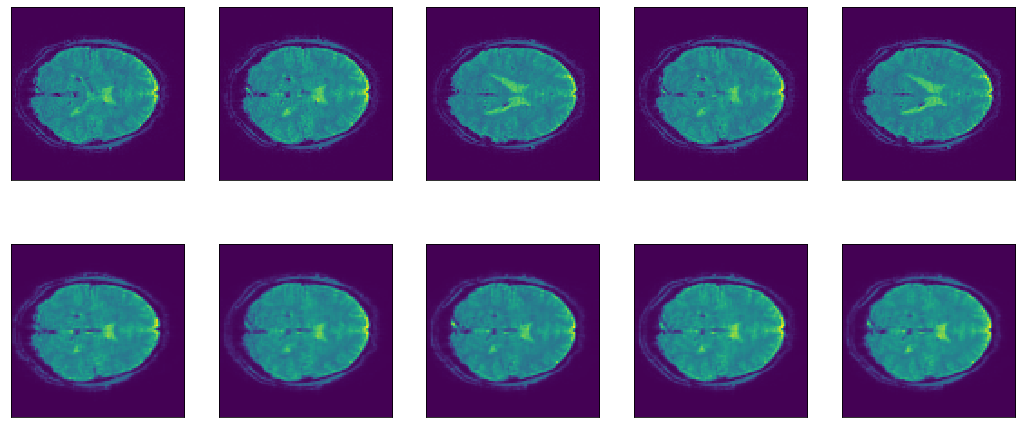

In [16]:
epoch_id=10
vis.plot_img_and_recon(OUTPUT, epoch_id=epoch_id, cmap='viridis')

Shape of img data:
(20, 1, 96, 96)
Shape of recon:
(20, 1, 96, 96)


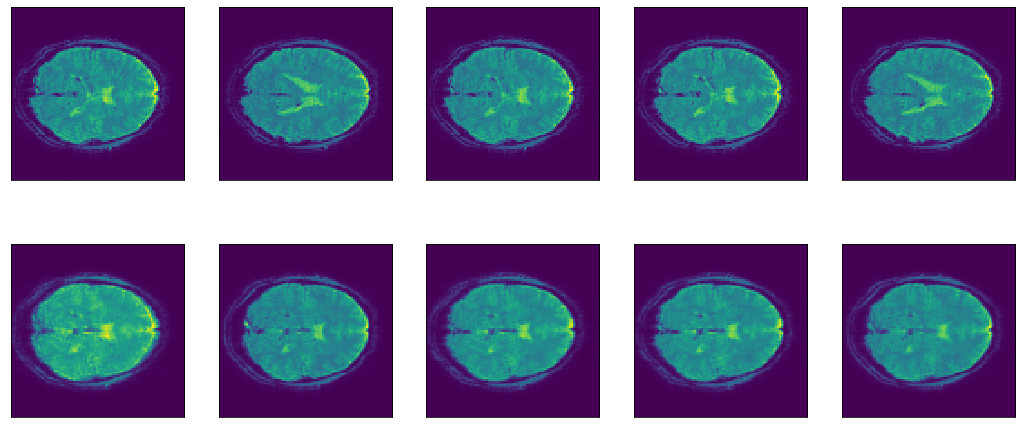

In [18]:
epoch_id=20
vis.plot_img_and_recon(OUTPUT, epoch_id=epoch_id, cmap='viridis')

Shape of img data:
(20, 1, 96, 96)
Shape of recon:
(20, 1, 96, 96)


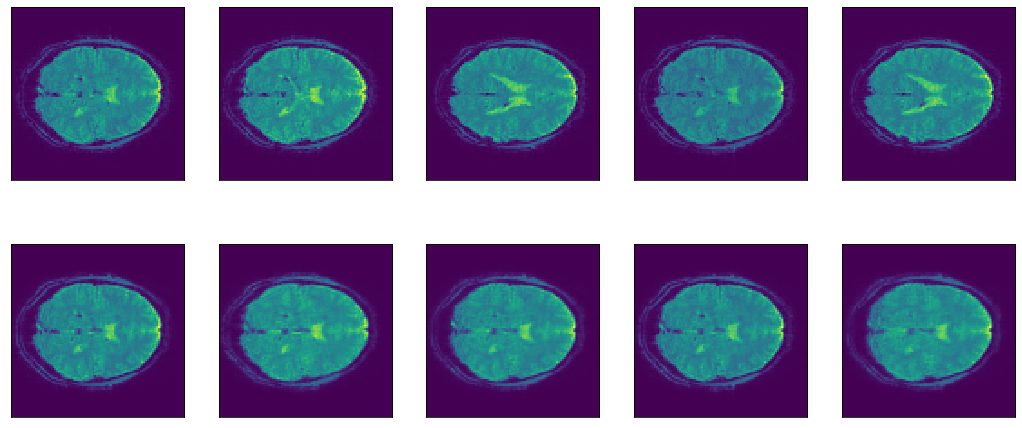

In [17]:
epoch_id=50
vis.plot_img_and_recon(OUTPUT, epoch_id=epoch_id, cmap='viridis')

Shape of img data:
(20, 1, 96, 96)
Shape of recon:
(20, 1, 96, 96)


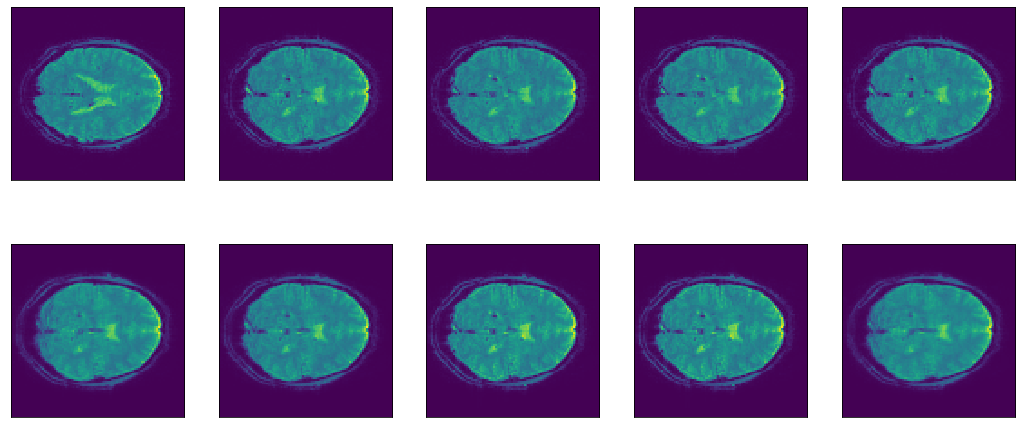

In [19]:
epoch_id=76
vis.plot_img_and_recon(OUTPUT, epoch_id=epoch_id, cmap='viridis')

### Inspect training

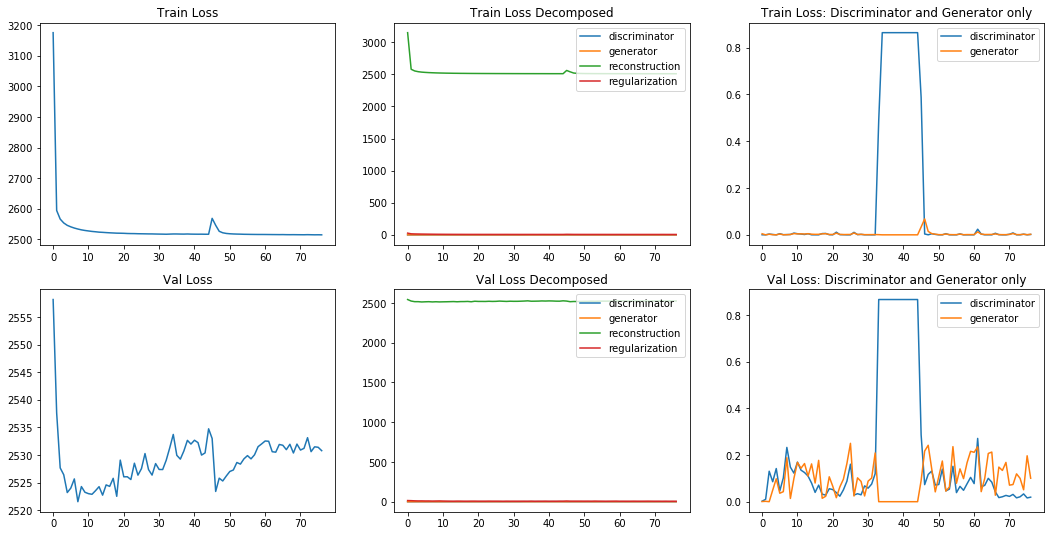

In [69]:
epoch_id = 76
vis.plot_losses(OUTPUT, epoch_id=epoch_id)

# 2. Inspect the latent space

## Standard PCA on the means of the approximation of the posterior

### Load test set and compute latent codes

## Gaussian Kernel Density Estimation

Getting all the projected_mus in 2D and corresponding labels

Loading: /scratch/users/nmiolane/output_fmri/training/models/epoch_8_encoder_train_loss_2531.2371_val_loss_2524.2953.pth


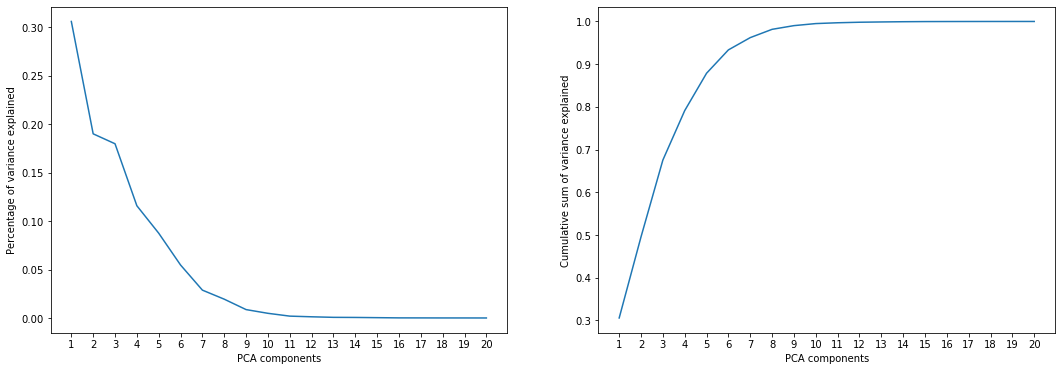

In [70]:
ax = vis.plot_variance_explained(OUTPUT, TRAIN_IMG_PATH, epoch_id=8)

In [71]:
projected_mus_2d, labels = analyze.get_subset_fmri(OUTPUT, METADATA_CSV)

Last checkpoint:  /scratch/users/nmiolane/output_fmri/training/models/epoch_77_encoder_train_loss_2515.1074_val_loss_2533.1335.pth


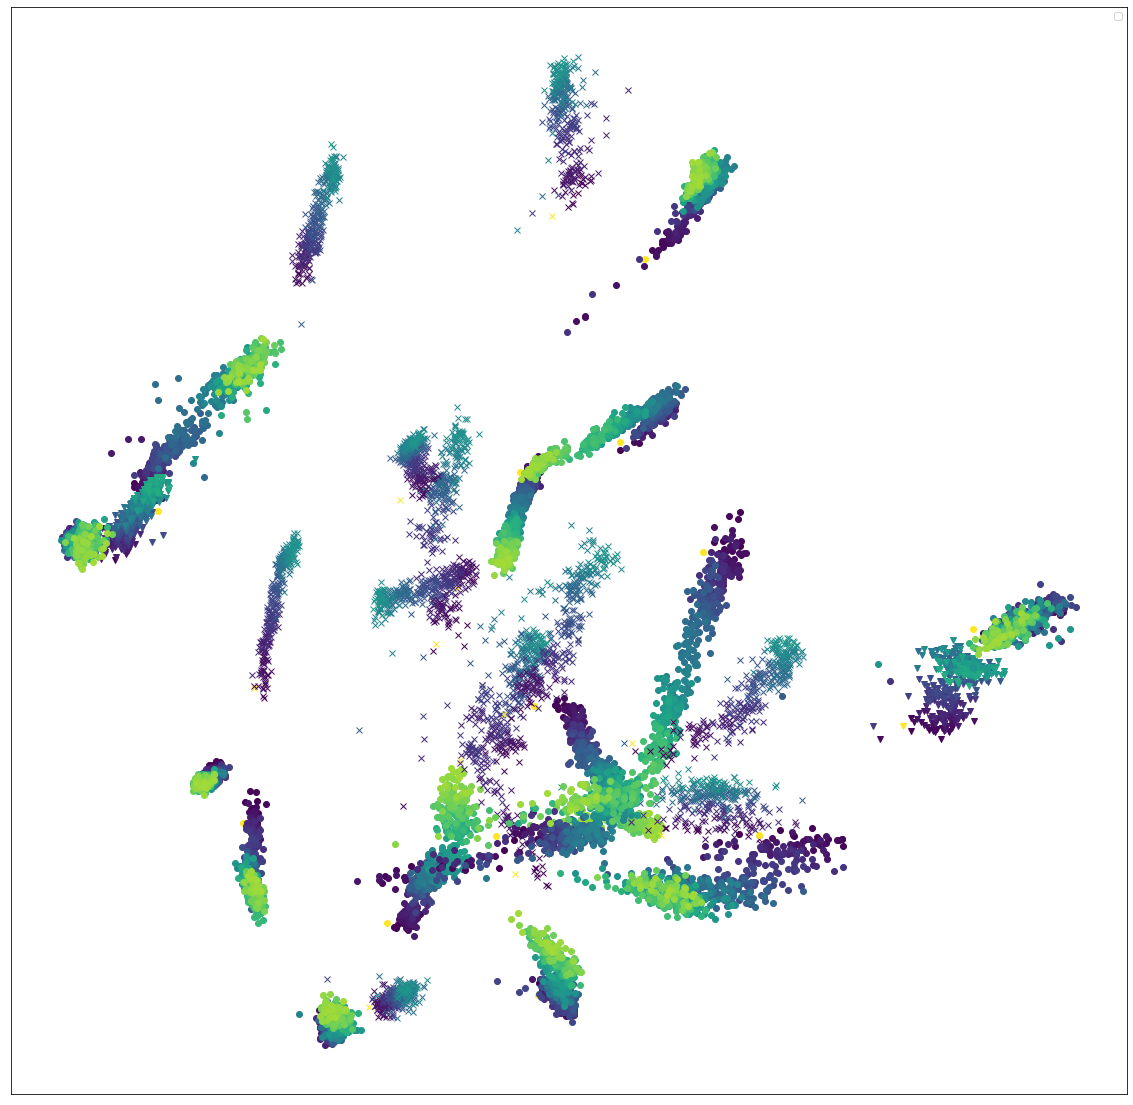

In [72]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 20))
im, ax = vis.plot_fmri(ax, projected_mus_2d, labels, marker_label='task')

69


No handles with labels found to put in legend.


70


No handles with labels found to put in legend.


71


No handles with labels found to put in legend.


72


No handles with labels found to put in legend.


73


No handles with labels found to put in legend.


74


No handles with labels found to put in legend.


75


No handles with labels found to put in legend.


76


No handles with labels found to put in legend.


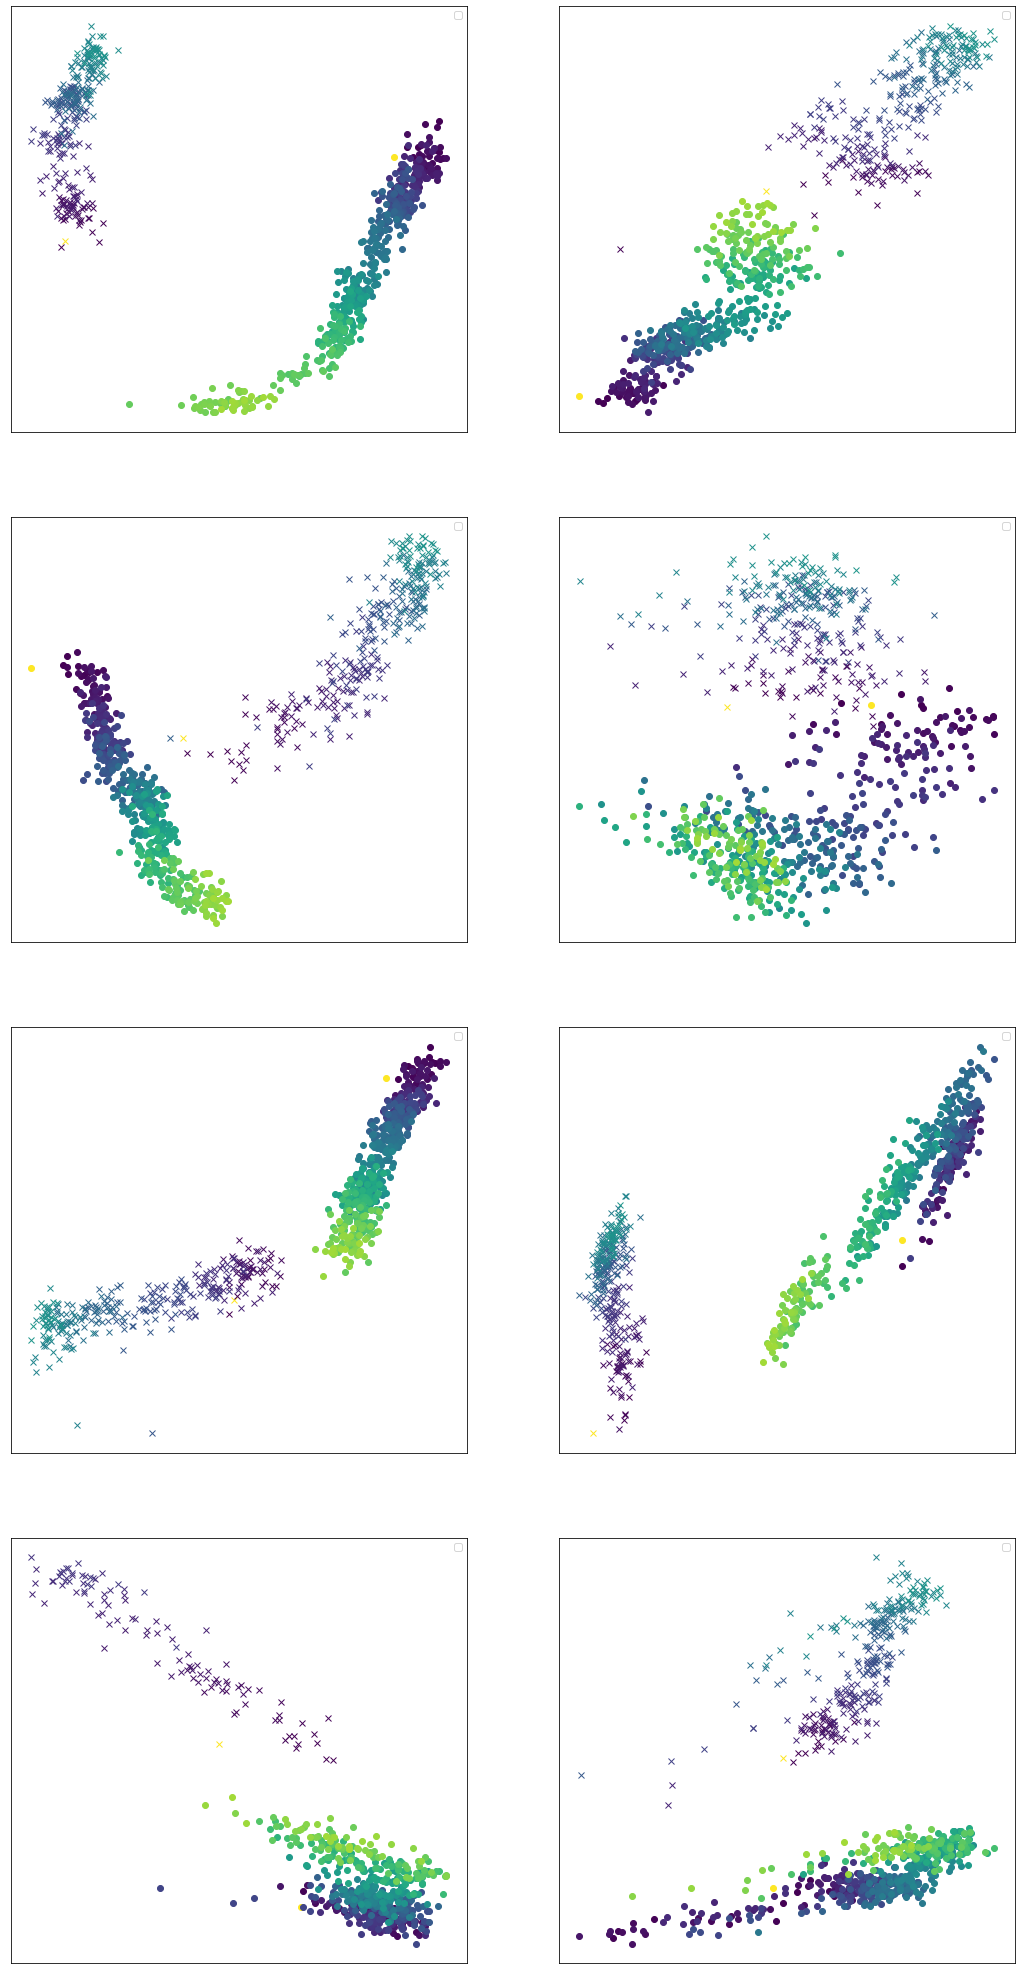

In [73]:
nrows = 4
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 36))

for i_ses, ses_id in enumerate(range(69, 77)):
    print(ses_id)
    ax = axes[int(i_ses // ncols), int(i_ses % ncols)]
    im, ax = vis.plot_fmri(ax, projected_mus_2d, labels, marker_label='task', ses_ids=[ses_id])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.legend()